# Peak analysis from MACS2 output

This notebook analyzes peaks from MACS2 output.

1. Calculate average peak position from replicates

2. Identify nearest ORF adjacent to each peak and plot distribution of distance to the nearest ORF

3. Cross-reference peaks with RNA-seq table and assign "activate" or "repressed" type to each peak

In [4]:
import os
import sys
import re


SCRIPTS = "/Users/yunfei/GeisingerLab/2023ChipSeq/src"
print(sys.version)


3.11.3 (main, May 15 2023, 10:43:03) [Clang 14.0.6 ]


In [25]:
%pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 7.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Calculate average peak position from replicates

### Use bedtools multiinter to identify intersected peaks

In [33]:
INDIR = "/Users/yunfei/2023_ChipSeq/MACS2_output_500k_ext200_input28-2/narrowPeak"
OUTDIR = "/Users/yunfei/2023_ChipSeq/bed_multiinter"

!mkdir -p $OUTDIR

for seed in [1, 4, 7]:
    for sample in [28, 49]:
        replicates = []
        for file in os.listdir(INDIR):
            if sample == 28: # for 28, only include replicate 2, and populate the list with 3 x replicate 2
                if re.match("^.+" + str(sample) + "-2.seed" + str(seed) + ".+$", file):
                    replicates.append(os.path.join(INDIR, file))
            else:
                if re.match("^.+" + str(sample) + "-\d.seed" + str(seed) + ".+$", file):
                    replicates.append(os.path.join(INDIR, file))
        if len(replicates) == 1:
            replicates += replicates
        outfile =os.path.join(OUTDIR, ("BfmR-ChIP-" + str(sample) + "_seed" + str(seed) + ".intersect.bed"))
        cmd = "bedtools multiinter -cluster -header -i " + " ".join(replicates) + " > " + outfile # 23Feb2023: added -header option so the output contains file path
        os.system(cmd)

### Calculate average peak position


In [2]:
INDIR = "/Users/yunfei/2023_ChipSeq/bed_multiinter"
OUTDIR = "/Users/yunfei/2023_ChipSeq/average_peak_summit"
SCRIPT = "/Users/yunfei/GeisingerLab/2023ChipSeq/src/find_peak_summit.py"
!mkdir -p $OUTDIR

for file in os.listdir(INDIR):
    if re.match("^.+" + "intersect.bed$", file):
        infile = os.path.join(INDIR, file)
        outfile = os.path.join(OUTDIR, (file.split('.')[0] + '.average_summit.bed'))
        cmd = "python " + SCRIPT + " " + infile + " " + outfile
        print("new output: " + outfile)
        os.system(cmd)

new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-28_seed4.average_summit.bed
new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-49_seed1.average_summit.bed
new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-28_seed7.average_summit.bed
new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-49_seed7.average_summit.bed
new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-28_seed1.average_summit.bed
new output: /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-49_seed4.average_summit.bed


In [3]:
!head /Users/yunfei/2023_ChipSeq/average_peak_summit/BfmR-ChIP-49_seed1.average_summit.bed

	chrom	start	end	original_peak_offset	average_summit	original_enrichment	average_enrichment
0	NC_009083.1	11173	11424	105;148;144	11305	2.07;1.94;2.04	2.02
1	NC_009084.1	7031	7255	59;144	7132	1.56;1.42	1.49
2	NZ_CP012004.1	3457	3849	196;179;203	3649	2.97;2.99;2.89	2.95
3	NZ_CP012004.1	43135	43331	110;58;124	43232	1.98;2.06;2.52	2.19
4	NZ_CP012004.1	47457	47702	130;159;165	47608	1.94;2.04;2.27	2.08
5	NZ_CP012004.1	58797	59014	82;119	58897	2.10;1.92	2.01
6	NZ_CP012004.1	63403	63664	173;165;136	63561	2.63;2.46;2.12	2.40
7	NZ_CP012004.1	100124	100276	100;172	100260	2.07;1.77	1.92
8	NZ_CP012004.1	104829	105226	287;325;250	105116	3.47;4.35;4.43	4.08


### Find nearest ORF adjacent to each peak

In [15]:
from matplotlib import pyplot as plt
from Bio import SeqIO
from scipy.stats import norm
from bisect import bisect_left

INDIR = "/Users/yunfei/2023_ChipSeq/average_peak_summit"
ANNOTATION = "/Users/yunfei/2023_ChipSeq/annotations"
OUTDIR = "/Users/yunfei/2023_ChipSeq/peak_stat"
SCRIPT = "/Users/yunfei/GeisingerLab/2023ChipSeq/src/distance_to_orf.py"

!mkdir -p $OUTDIR

for file in os.listdir(INDIR):
    if re.match("^.+" + "average_summit.bed$", file):
        infile = os.path.join(INDIR, file)
        outfile = os.path.join(OUTDIR, (file.split('.')[0] + '.nearest_orf.tsv'))
        plot = os.path.join(OUTDIR, (file.split('.')[0] + '.nearest_orf.tiff'))
        cmd = "python " + SCRIPT + " " + infile + " " + ANNOTATION + " " + outfile + " " + plot
        print("new output: " + outfile)
        os.system(cmd)

new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-28_seed1.nearest_orf.tsv
new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-28_seed4.nearest_orf.tsv
new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-28_seed7.nearest_orf.tsv
new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-49_seed1.nearest_orf.tsv
new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-49_seed7.nearest_orf.tsv
new output: /Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-49_seed4.nearest_orf.tsv


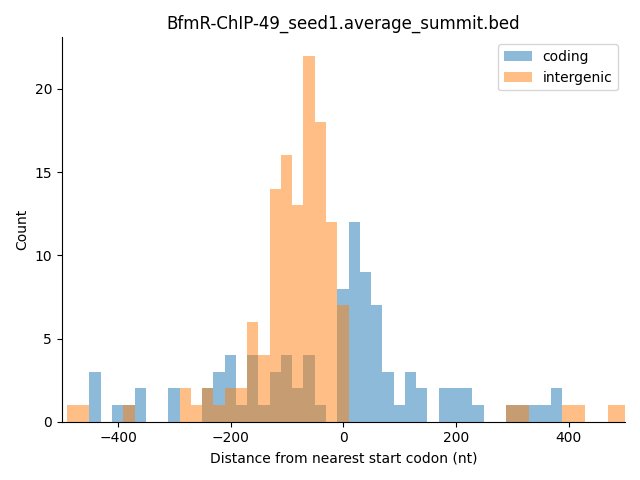

In [19]:
from PIL import Image
Image.open("/Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-49_seed1.nearest_orf.tiff")

### Link peak stat with RNASeq tables

In [27]:
import pandas as pd

rnaseq_bfmRS = "/Users/yunfei/2023_ChipSeq/rnaseq/bfmRS_WT.xlsx"
rnaseq_bfmR = "/Users/yunfei/2023_ChipSeq/rnaseq/bfmR_WT.xlsx"
rnaseq_bfmS = "/Users/yunfei/2023_ChipSeq/rnaseq/bfmS_WT.xlsx"

infile = "/Users/yunfei/2023_ChipSeq/peak_stat/BfmR-ChIP-49_seed1.nearest_orf.tsv"
outdir = "/Users/yunfei/2023_ChipSeq/RNAseq_Chipseq_mastertable/"
!mkdir -p $outdir
outfile = "BfmR-ChIP-49_seed1.master_table.tsv"
outfile = os.path.join(outdir, outfile)

def read_rnaseq_table(file):
    df = pd.read_excel(file)
    df = df.set_index("gene_id")
    return df

rnaseq_table = {}
rnaseq_table.update({"BfmRS_WT" : read_rnaseq_table(rnaseq_bfmRS)})
rnaseq_table.update({"BfmR_WT" : read_rnaseq_table(rnaseq_bfmR)})
rnaseq_table.update({"BfmS_WT" : read_rnaseq_table(rnaseq_bfmS)})

test_table = read_rnaseq_table(rnaseq_bfmRS)

df_chipseq = pd.read_csv(infile, sep='\t', index_col=0)
df_chipseq = df_chipseq.set_index("locus_tag")

col_names = ["log2(fold_change)", "significant", "protein_id", "product"]

for i,j in rnaseq_table.items():
    df_rnaseq = j
    for row, column in df_chipseq.iterrows():
        for k in col_names:
            new_column_name = i + "_" + k
            try:
                df_chipseq.loc[row, new_column_name] = df_rnaseq.loc[row,k]
            except:
                pass
df_chipseq.to_csv(outfile, sep='\t')

df_chipseq

/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/Users/yunfei/opt/anaconda3/envs/ChipSeq/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,chrom,start,end,strand,summit_pos,distance_to_match,match_type,average_fold_enrichment,BfmRS_WT_log2(fold_change),BfmRS_WT_significant,BfmRS_WT_protein_id,BfmRS_WT_product,BfmR_WT_log2(fold_change),BfmR_WT_significant,BfmR_WT_protein_id,BfmR_WT_product,BfmS_WT_log2(fold_change),BfmS_WT_significant,BfmS_WT_protein_id,BfmS_WT_product
locus_tag,,,,,,,,,,,,,,,,,,,,
A1S_3469,NC_009083.1,10723,10366,-1,11305,-582,intergenic,2.02,1.208900,yes,YP_001083093.1,diaminopimelate decarboxylase,1.398850,yes,YP_001083093.1,diaminopimelate decarboxylase,0.297624,no,YP_001083093.1,diaminopimelate decarboxylase
A1S_3475,NC_009084.1,6196,8608,1,7132,936,coding,1.49,1.750410,yes,YP_001083098.1,hypothetical protein,1.417840,yes,YP_001083098.1,hypothetical protein,0.426927,no,YP_001083098.1,hypothetical protein
ACX60_RS00020,NZ_CP012004.1,3882,6351,1,3649,-233,coding,2.95,-0.443899,no,WP_000093728.1,DNA gyrase subunit B,-0.622859,yes,WP_000093728.1,DNA gyrase subunit B,-0.128250,no,WP_000093728.1,DNA gyrase subunit B
ACX60_RS00175,NZ_CP012004.1,44855,45233,1,43232,-1623,coding,2.19,-0.316215,no,WP_000529425.1,membrane protein,-0.660396,yes,WP_000529425.1,membrane protein,-1.036260,yes,WP_000529425.1,membrane protein
ACX60_RS00195,NZ_CP012004.1,47969,48623,1,47608,-361,coding,2.08,-1.153530,yes,WP_001036017.1,hypothetical protein,-0.894781,yes,WP_001036017.1,hypothetical protein,-0.427205,no,WP_001036017.1,hypothetical protein
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACX60_RS18560,NZ_CP012005.1,65113,64201,-1,65314,-201,intergenic,2.52,0.253962,no,WP_002015149.1,hypothetical protein,-0.067124,no,WP_002015149.1,hypothetical protein,-1.101010,yes,WP_002015149.1,hypothetical protein
ACX60_RS18565,NZ_CP012005.1,66532,65428,-1,66226,306,coding,3.62,-0.012821,no,WP_001101323.1,hypothetical protein,0.001910,no,WP_001101323.1,hypothetical protein,-0.178821,no,WP_001101323.1,hypothetical protein
ACX60_RS18580,NZ_CP012005.1,69824,69419,-1,69347,477,intergenic,2.24,1.614120,yes,WP_000386247.1,hypothetical protein,1.166190,yes,WP_000386247.1,hypothetical protein,-1.016900,yes,WP_000386247.1,hypothetical protein


In [28]:
!head /Users/yunfei/2023_ChipSeq/RNAseq_Chipseq_mastertable/BfmR-ChIP-49_seed1.master_table.tsv

locus_tag	chrom	start	end	strand	summit_pos	distance_to_match	match_type	average_fold_enrichment	BfmRS_WT_log2(fold_change)	BfmRS_WT_significant	BfmRS_WT_protein_id	BfmRS_WT_product	BfmR_WT_log2(fold_change)	BfmR_WT_significant	BfmR_WT_protein_id	BfmR_WT_product	BfmS_WT_log2(fold_change)	BfmS_WT_significant	BfmS_WT_protein_id	BfmS_WT_product
A1S_3469	NC_009083.1	10723	10366	-1	11305	-582	intergenic	2.02	1.2089	yes	YP_001083093.1	diaminopimelate decarboxylase	1.39885	yes	YP_001083093.1	diaminopimelate decarboxylase	0.297624	no	YP_001083093.1	diaminopimelate decarboxylase
A1S_3475	NC_009084.1	6196	8608	1	7132	936	coding	1.49	1.75041	yes	YP_001083098.1	hypothetical protein	1.41784	yes	YP_001083098.1	hypothetical protein	0.426927	no	YP_001083098.1	hypothetical protein
ACX60_RS00020	NZ_CP012004.1	3882	6351	1	3649	-233	coding	2.95	-0.443899	no	WP_000093728.1	DNA gyrase subunit B	-0.622859	yes	WP_000093728.1	DNA gyrase subunit B	-0.12825	no	WP_000093728.1	DNA gyrase subunit B
ACX60_RS00175	NZ